In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
import xgboost as xgb

# Loading the Dataset
This section loads the training and test datasets and saves the `Id` column from the test set for submission.

In [4]:
## Loading the Dataset
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
ids = df_test['Id'].values


# **Data Overview**
This section provides a basic overview of the training dataset, including:
- First few rows of the dataset.
- Summary statistics.
- Checking for missing values.


In [5]:

# Check the first few rows
print(df_train.head())

# Summary statistics
print(df_train.describe())

# Check for null values
print(df_train.isnull().sum().sort_values(ascending=False))


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# **Exploratory Data Analysis (EDA)**
This section includes visualizations to analyze the `SalePrice` distribution, relationships with key features, and feature correlations.


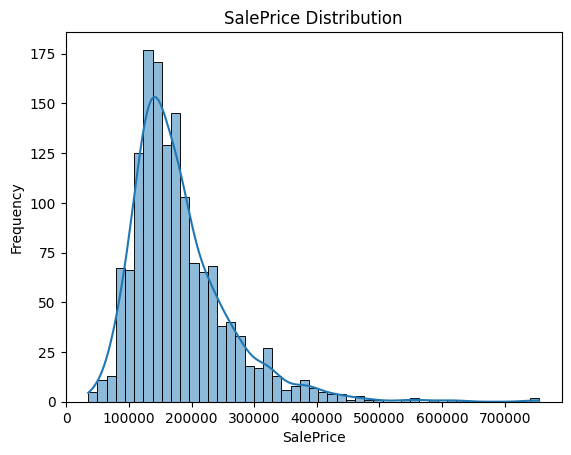

Skewness: 1.880940746034036
Kurtosis: 6.536281860064529


In [6]:

# Distribution of SalePrice
sns.histplot(df_train['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Skewness and Kurtosis
print("Skewness:", skew(df_train['SalePrice']))
print("Kurtosis:", df_train['SalePrice'].kurt())


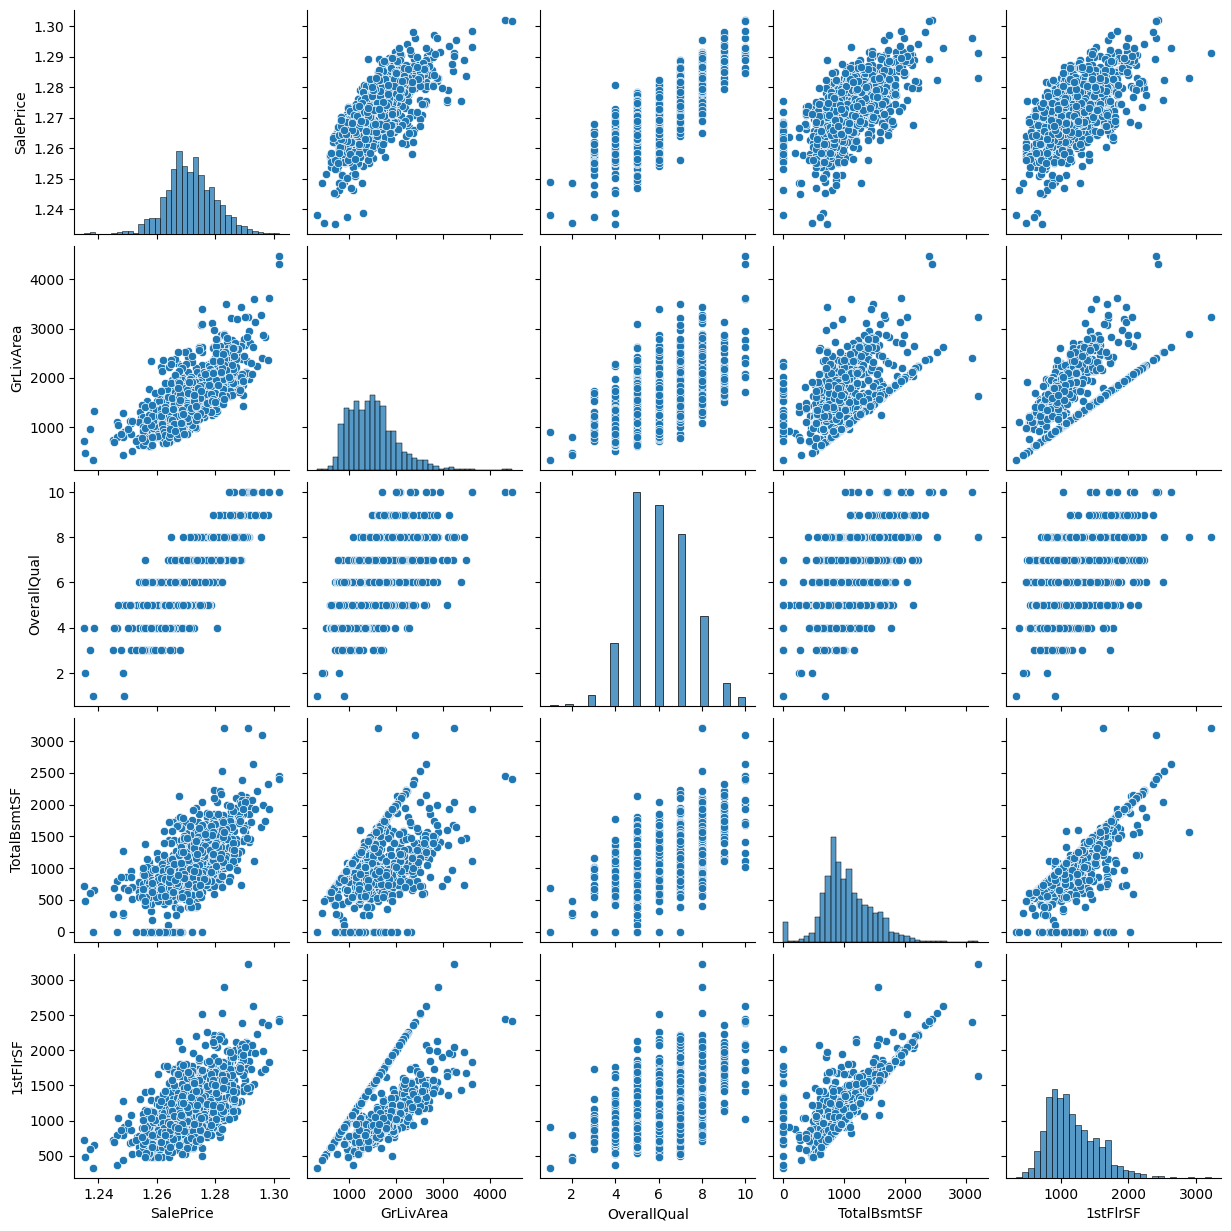

In [34]:
# Pair plot for numerical features
sns.pairplot(df_train[['SalePrice', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', '1stFlrSF']])
plt.show()


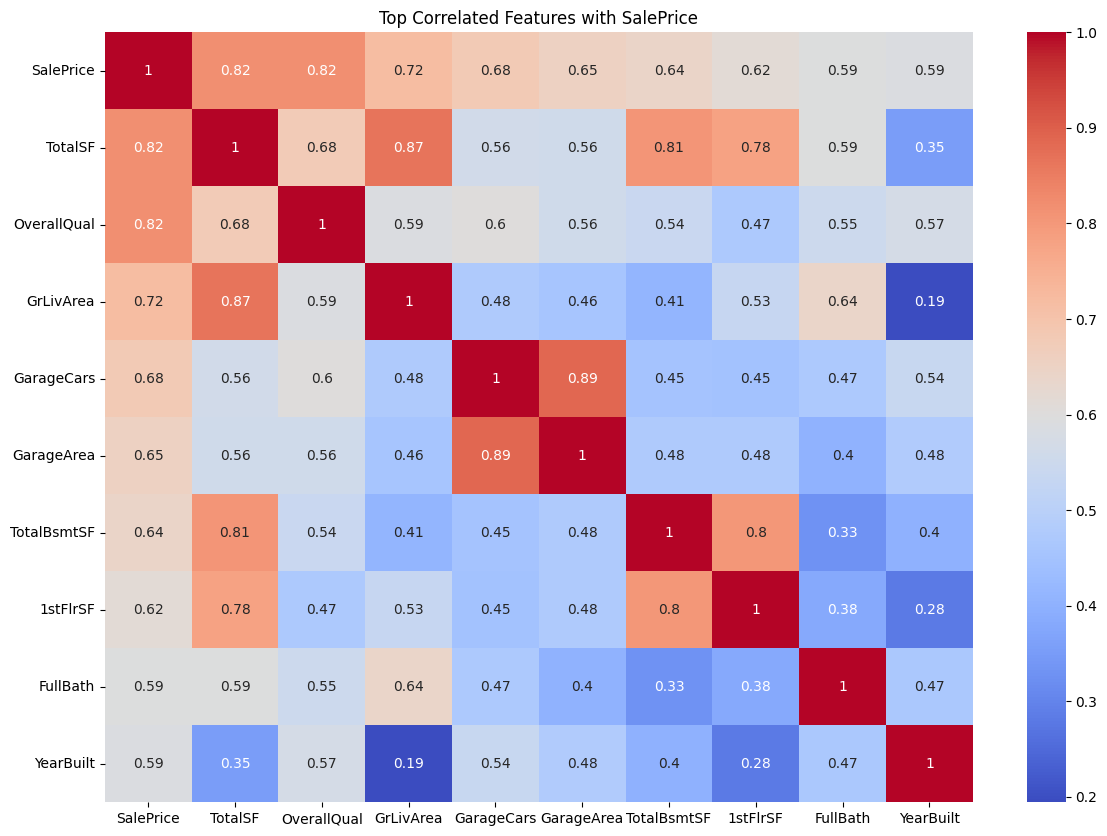

In [35]:
# Correlation heatmap with a focus on top correlated features
plt.figure(figsize=(14, 10))
corr_matrix = df_train.corr()
top_corr = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
sns.heatmap(df_train[top_corr].corr(), annot=True, cmap="coolwarm")
plt.title('Top Correlated Features with SalePrice')
plt.show()


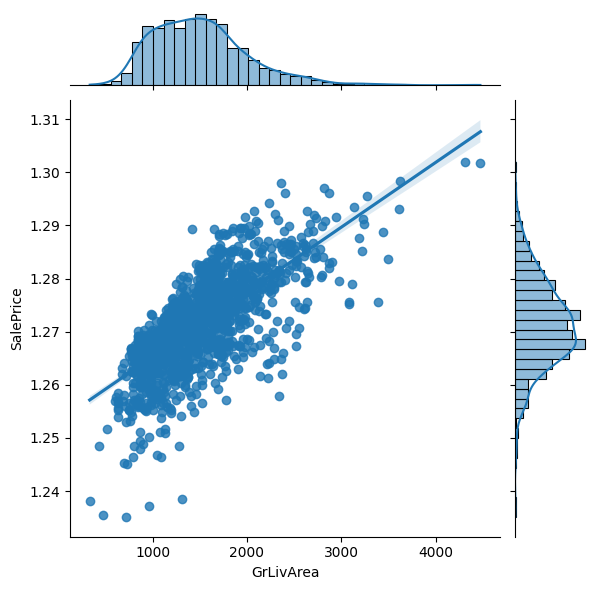

In [36]:
# SalePrice vs. GrLivArea with distribution
sns.jointplot(x='GrLivArea', y='SalePrice', data=df_train, kind='reg')
plt.show()


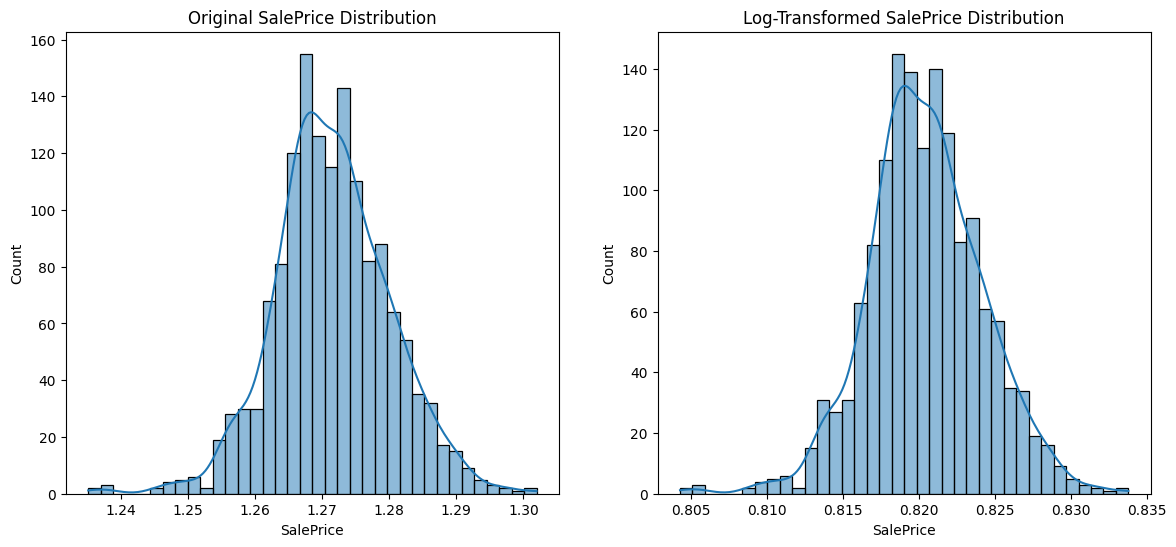

In [37]:
# Distribution of SalePrice before and after log transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df_train['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title('Original SalePrice Distribution')

sns.histplot(np.log1p(df_train['SalePrice']), kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed SalePrice Distribution')
plt.show()

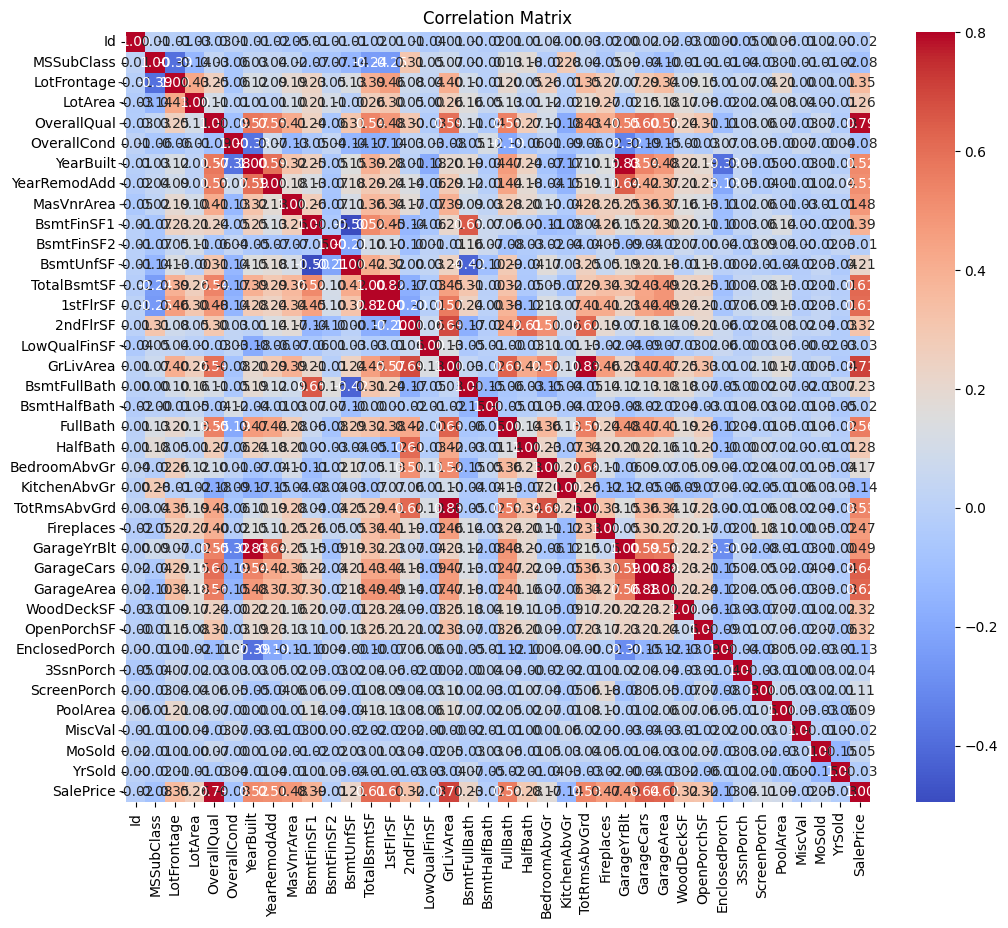

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


In [8]:
# Ensure only numeric columns are included for correlation matrix
numeric_features = df_train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = numeric_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', vmax=.8)
plt.title('Correlation Matrix')
plt.show()

# Most correlated features with SalePrice
corr_target = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_target.head(10))


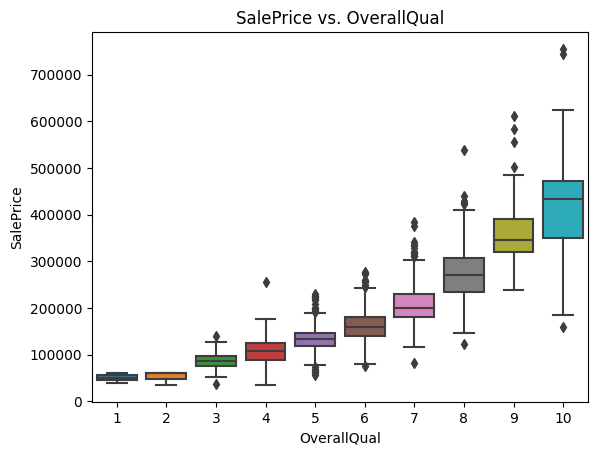

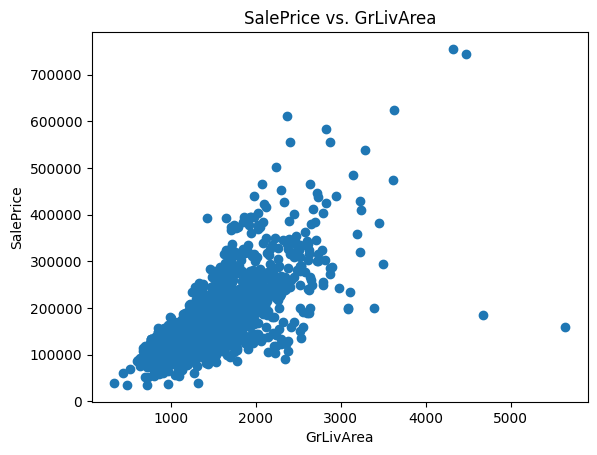

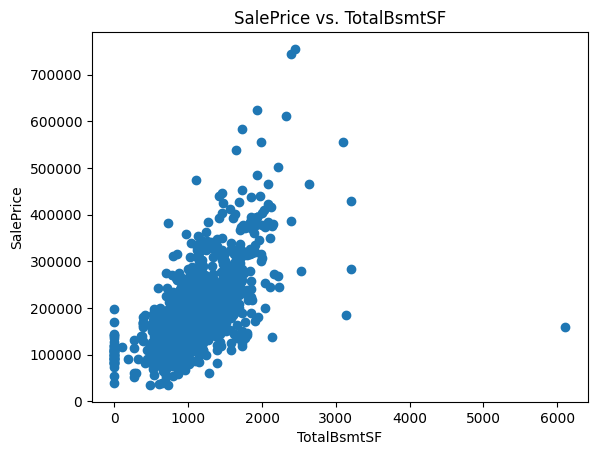

In [9]:

# OverallQual vs. SalePrice
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)
plt.title('SalePrice vs. OverallQual')
plt.show()

# GrLivArea vs. SalePrice
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.title('SalePrice vs. GrLivArea')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

# TotalBsmtSF vs. SalePrice
plt.scatter(df_train['TotalBsmtSF'], df_train['SalePrice'])
plt.title('SalePrice vs. TotalBsmtSF')
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')
plt.show()

# **Outlier Detection and Removal**
This section identifies and removes outliers in the `GrLivArea` feature.


Outliers to remove: Index([523, 1298], dtype='int64')


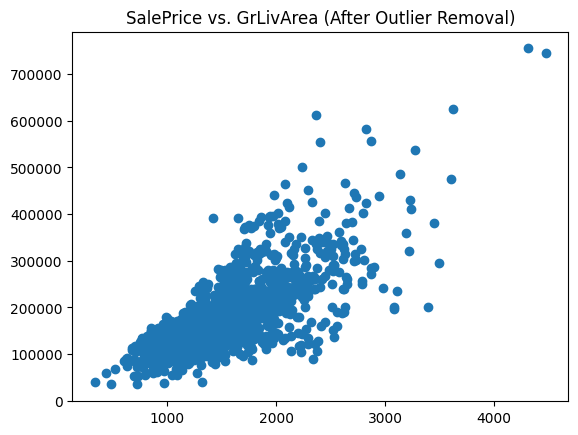

In [10]:

# Remove outliers for GrLivArea
outliers = df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index
print("Outliers to remove:", outliers)

# Dropping outliers
df_train = df_train.drop(outliers)

# Re-plotting GrLivArea vs. SalePrice
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.title('SalePrice vs. GrLivArea (After Outlier Removal)')
plt.show()


# **Handling Missing Values**
This section fills missing values in the training dataset using appropriate strategies based on the feature types.


PoolQC          99.588477
MiscFeature     96.296296
Alley           93.758573
Fence           80.727023
MasVnrType      59.807956
FireplaceQu     47.325103
LotFrontage     17.764060
GarageType       5.555556
GarageYrBlt      5.555556
GarageFinish     5.555556
GarageQual       5.555556
GarageCond       5.555556
BsmtFinType2     2.606310
BsmtExposure     2.606310
BsmtFinType1     2.537723
BsmtCond         2.537723
BsmtQual         2.537723
MasVnrArea       0.548697
Electrical       0.068587
dtype: float64


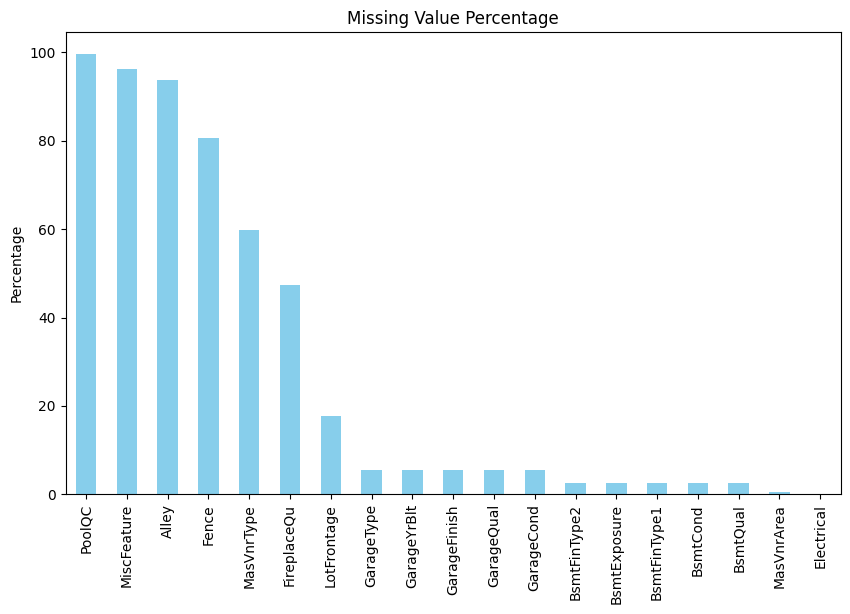

Remaining missing values: 872


In [11]:

# Percentage of missing values
missing = df_train.isnull().sum() / len(df_train) * 100
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

# Visualizing missing values
plt.figure(figsize=(10, 6))
missing.plot(kind='bar', color='skyblue')
plt.title('Missing Value Percentage')
plt.ylabel('Percentage')
plt.show()

# Filling missing values
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    df_train[col] = df_train[col].fillna('None')

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df_train[col] = df_train[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df_train[col] = df_train[col].fillna('None')

# Remaining missing values
print("Remaining missing values:", df_train.isnull().sum().max())


In [12]:
# Identify columns with remaining missing values
remaining_missing = df_train.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining missing values:\n", remaining_missing)

# Impute missing values based on column types
for col in remaining_missing.index:
    if df_train[col].dtype == "object":
        # Fill categorical columns with the most frequent value
        df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
    else:
        # Fill numerical columns with the median value
        df_train[col] = df_train[col].fillna(df_train[col].median())

# Verify no missing values remain
print("Remaining missing values after imputation:", df_train.isnull().sum().max())


Columns with remaining missing values:
 LotFrontage    259
MasVnrType     872
MasVnrArea       8
Electrical       1
dtype: int64
Remaining missing values after imputation: 0


# **Feature Engineering**
This section performs feature engineering, including:
- Log-transforming the target variable (`SalePrice`).
- Encoding categorical variables.
- Creating a new feature, `TotalSF`.


In [15]:

# Log-transforming SalePrice to reduce skewness
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# Encoding categorical variables
categorical_features = df_train.select_dtypes(include=['object']).columns
for col in categorical_features:
    lbl = LabelEncoder()
    df_train[col] = lbl.fit_transform(df_train[col])

# Adding TotalSF feature
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']


# **Data Preparation for Modeling**
This section splits the data into training and validation sets.


In [16]:

# Separating features and target
X = df_train.drop(['SalePrice', 'Id'], axis=1)
y = df_train['SalePrice']

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# **Training Baseline Models**
Train baseline models: Random Forest, XGBoost, and Gradient Boosting.
Evaluate their performance using RMSLE.


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=500, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=500, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_val)

# Calculate RMSLE for all models
rf_rmsle = np.sqrt(mean_squared_error(y_val, rf_pred))
xgb_rmsle = np.sqrt(mean_squared_error(y_val, xgb_pred))
gb_rmsle = np.sqrt(mean_squared_error(y_val, gb_pred))

print("Random Forest RMSLE:", rf_rmsle)
print("XGBoost RMSLE:", xgb_rmsle)
print("Gradient Boosting RMSLE:", gb_rmsle)


Random Forest RMSLE: 0.0031740904760869126
XGBoost RMSLE: 0.0032517692981022654
Gradient Boosting RMSLE: 0.0028198724327202986


# **Stacking Models**
This section implements stacking with ElasticNet, Gradient Boosting, and Kernel Ridge as base models and Lasso as the meta-model.


In [28]:
ensemble_rmsle = np.sqrt(mean_squared_error(y_val, ensemble))
print("Stacked Model Ensemble RMSLE:", ensemble_rmsle)


Stacked Model Ensemble RMSLE: 0.0027984691638079334


# **Evaluation and Comparison**
Compare RMSLE scores of all models and visualize the results.


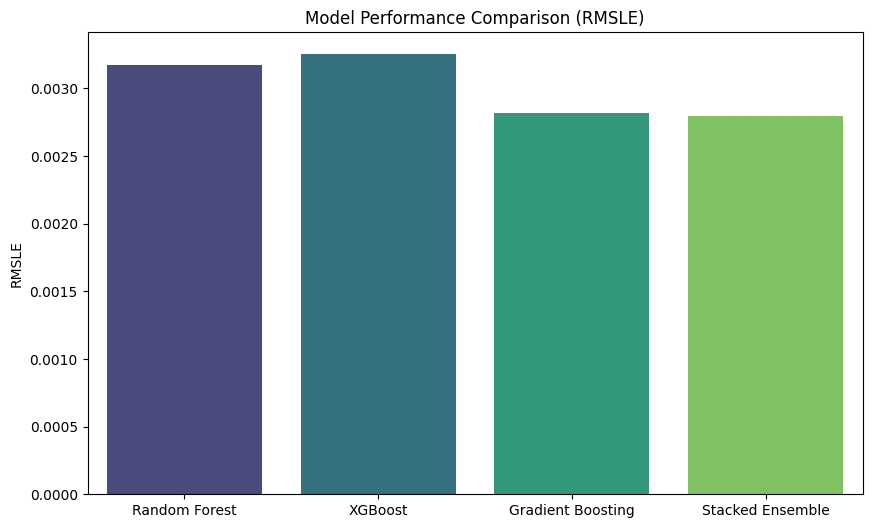

In [29]:
# Comparison of RMSLE scores
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'Stacked Ensemble']
rmsle_scores = [rf_rmsle, xgb_rmsle, gb_rmsle, ensemble_rmsle]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=rmsle_scores, palette="viridis")
plt.title('Model Performance Comparison (RMSLE)')
plt.ylabel('RMSLE')
plt.show()


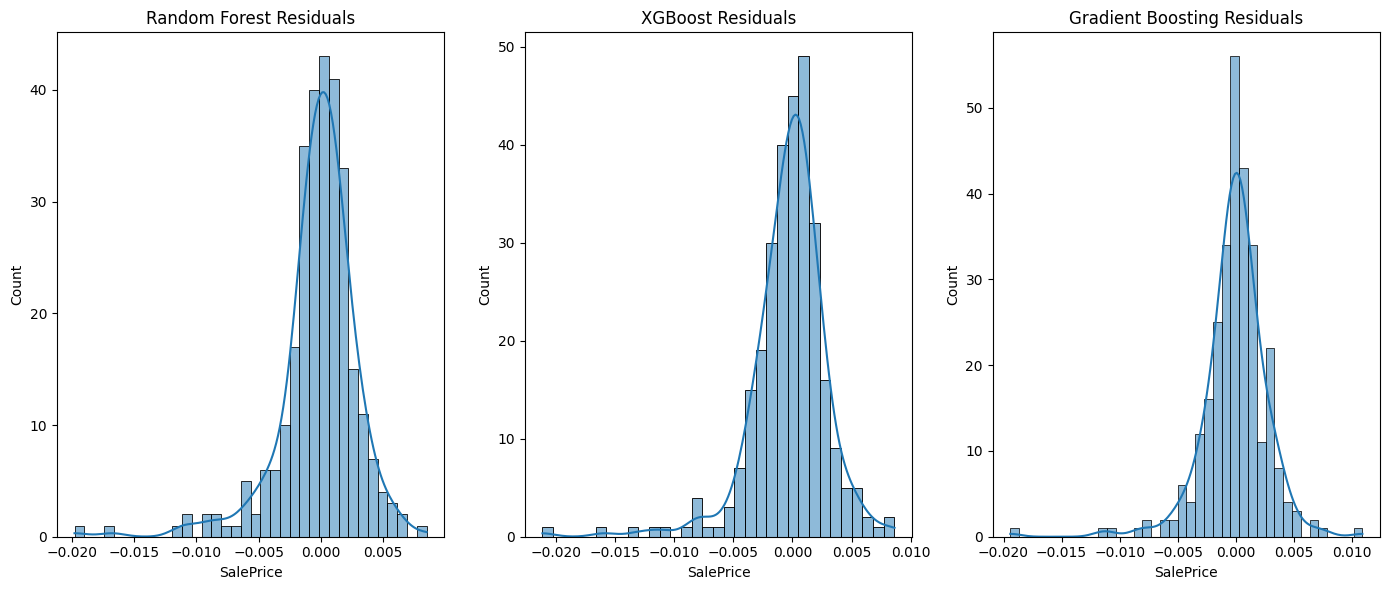

In [30]:
# Residuals for all models
rf_residuals = y_val - rf_pred
xgb_residuals = y_val - xgb_pred
gb_residuals = y_val - gb_pred

# Plot residuals
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.histplot(rf_residuals, kde=True)
plt.title('Random Forest Residuals')

plt.subplot(1, 3, 2)
sns.histplot(xgb_residuals, kde=True)
plt.title('XGBoost Residuals')

plt.subplot(1, 3, 3)
sns.histplot(gb_residuals, kde=True)
plt.title('Gradient Boosting Residuals')
plt.tight_layout()
plt.show()


In [31]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)


# **Preparing for Submission**
This section prepares the test dataset and generates the submission file.


In [38]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, random_state=42)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, random_state=42))
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42))

stacked_averaged_models = StackingAveragedModels(base_models=(ENet, GBoost, KRR),
                                                 meta_model=lasso)

stacked_averaged_models.fit(X_train.values, y_train.values)
stk_pred = stacked_averaged_models.predict(X_val.values)

model_xgb = xgb.XGBRegressor(n_estimators=2200, nthread=-1, random_state=42)
model_xgb.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_val)

df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

# Handle categorical variables in the test dataset
categorical_features_test = df_test.select_dtypes(include=['object']).columns
for col in categorical_features_test:
    lbl = LabelEncoder()
    df_test[col] = lbl.fit_transform(df_test[col].astype(str))
if 'Id' in df_test.columns:
    df_test = df_test.drop(['Id'], axis=1)

# Submitting predictions
sub = pd.DataFrame()
sub['Id'] = ids
sub['SalePrice'] = np.expm1(model_xgb.predict(df_test))
sub.to_csv('submission.csv', index=False)
print('submission file saved successfully.')


submission file saved successfully.
